In [7]:
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from add_planck_galccs.generate_galcc_maps import galcc_mapper
import pysm3.units as u
import pandas as pd
import mapsims

df = pd.read_csv('PGCC.csv')
glons = df['glon']
glats = df['glat']
planck_map, h = hp.read_map("/global/homes/j/justinc/Galactic Cold Clumps/HFI_SkyMap_353_2048_R2.02_full.fits", h = True)
gnilc_map_353, gh3 = hp.read_map("/global/homes/j/justinc/Galactic Cold Clumps/Data/COM_CompMap_Dust-GNILC-F353_2048_R2.00.fits", h = True)
gnilc_map_545, gh5 = hp.read_map("/global/homes/j/justinc/Galactic Cold Clumps/Data/COM_CompMap_Dust-GNILC-F545_2048_R2.00.fits", h = True)
gnilc_map_857, gh8 = hp.read_map("/global/homes/j/justinc/Galactic Cold Clumps/Data/COM_CompMap_Dust-GNILC-F857_2048_R2.00.fits", h = True)

blank = galcc_mapper()
galccmap_353 = blank.galcc_map(catalogue = "PGCC.csv", 
                           freq_out = 353, 
                           nside = 2048, 
                           shape_circ = False,
                           store_maps = False, 
                           output_units = u.MJy/u.sr)

galccmap_545 = blank.galcc_map(catalogue = "PGCC.csv", 
                           freq_out = 545, 
                           nside = 2048, 
                           shape_circ = False,
                           store_maps = False, 
                           output_units = u.MJy/u.sr)

galccmap_857 = blank.galcc_map(catalogue = "PGCC.csv", 
                           freq_out = 857, 
                           nside = 2048, 
                           shape_circ = False,
                           store_maps = False, 
                           output_units = u.MJy/u.sr)

In [2]:
Planck_353 = mapsims.parse_channels("all", 
                    instrument_parameters = 'planck_deltabandpass')[6]
Planck_545 = mapsims.parse_channels("all", 
                    instrument_parameters = 'planck_deltabandpass')[7]
Planck_857 = mapsims.parse_channels("all", 
                    instrument_parameters = 'planck_deltabandpass')[8]
beam_353 = Planck_353.beam
beam_545 = Planck_545.beam
beam_857 = Planck_857.beam

In [3]:
combined_gnilcmap_353 = gnilc_map_353.copy()
combined_gnilcmap_545 = gnilc_map_545.copy()
combined_gnilcmap_857 = gnilc_map_857.copy()
combined_gnilcmap_353 += galccmap_353
combined_gnilcmap_545 += galccmap_545
combined_gnilcmap_857 += galccmap_857


smooth_353 = hp.smoothing(combined_gnilcmap_353, 
                            fwhm = beam_353.to_value(u.rad))
smooth_545 = hp.smoothing(combined_gnilcmap_545, 
                            fwhm = beam_545.to_value(u.rad))
smooth_857 = hp.smoothing(combined_gnilcmap_857, 
                            fwhm = beam_857.to_value(u.rad))

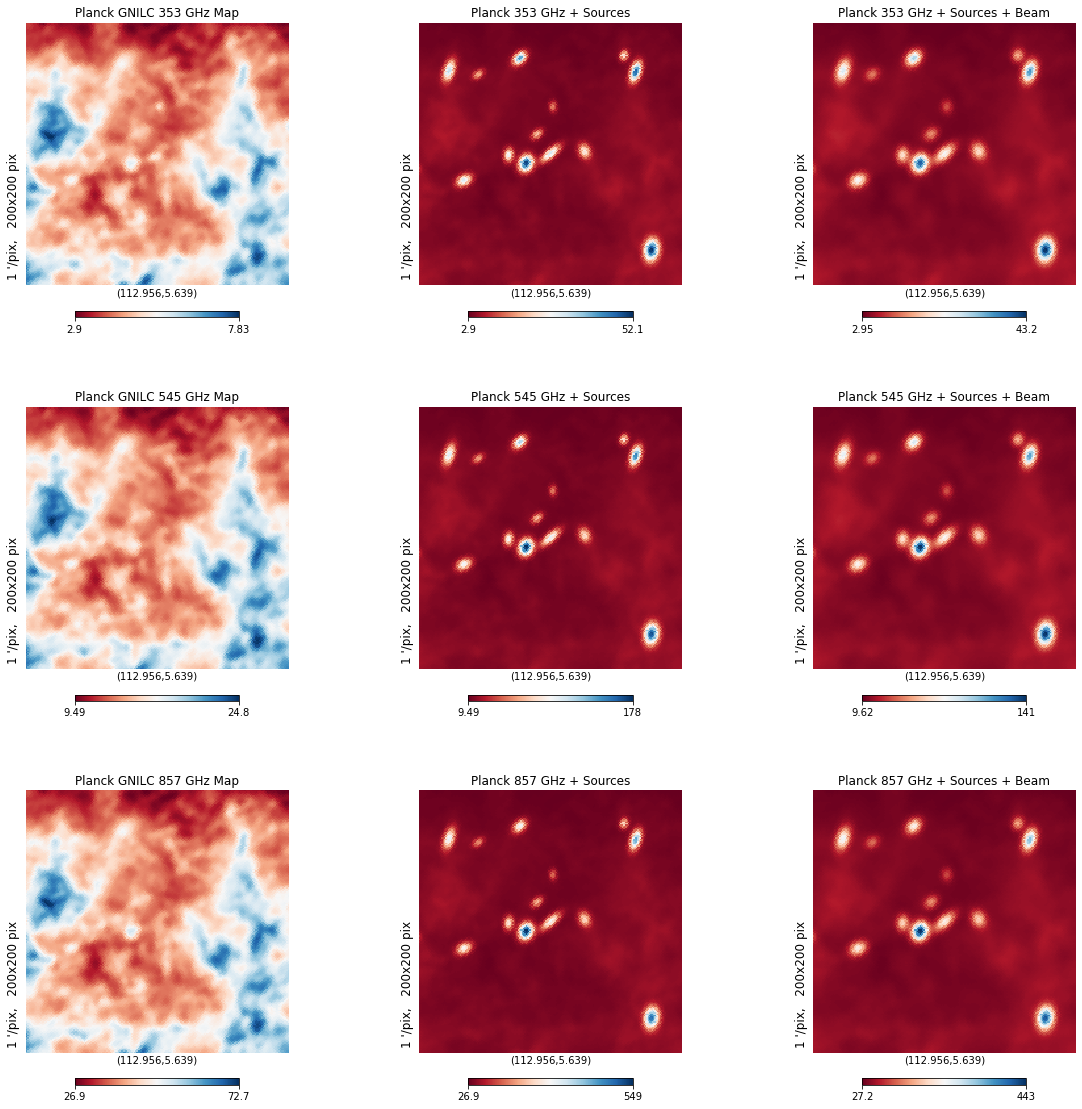

In [4]:
rot = [glons[1], glats[1]]

gs = gridspec.GridSpec(3, 3)
plt.figure(figsize = (20, 20))
ax = plt.subplot(gs[0, 0])
hp.gnomview(gnilc_map_353, rot = rot, reso = 1, 
            title = 'Planck GNILC 353 GHz Map', 
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[0, 1])
hp.gnomview(combined_gnilcmap_353, rot = rot, reso = 1, 
            title = 'Planck 353 GHz + Sources', 
            cmap = 'RdBu', hold = True)

ax = plt.subplot(gs[0, 2])
hp.gnomview(smooth_353, rot = rot, reso = 1, 
            title = 'Planck 353 GHz + Sources + Beam', 
            cmap = 'RdBu', hold = True)

ax = plt.subplot(gs[1, 0])
hp.gnomview(gnilc_map_545, rot = rot, reso = 1, 
            title = 'Planck GNILC 545 GHz Map', 
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 1])
hp.gnomview(combined_gnilcmap_545, rot = rot, reso = 1, 
            title = 'Planck 545 GHz + Sources', 
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[1, 2])
hp.gnomview(smooth_545, rot = rot, reso = 1, 
            title = 'Planck 545 GHz + Sources + Beam', 
            cmap = 'RdBu', hold = True)

ax = plt.subplot(gs[2, 0])
hp.gnomview(gnilc_map_857, rot = rot, reso = 1, 
            title = 'Planck GNILC 857 GHz Map', 
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[2, 1])
hp.gnomview(combined_gnilcmap_857, rot = rot, reso = 1, 
            title = 'Planck 857 GHz + Sources', 
            cmap = 'RdBu', hold = True)
ax = plt.subplot(gs[2, 2])
hp.gnomview(smooth_857, rot = rot, reso = 1, 
            title = 'Planck 857 GHz + Sources + Beam', 
            cmap = 'RdBu', hold = True)

In [6]:
df[df['glat'] > 30]

,name,glon,glat,ra,dec,snr,snr_857,snr_545,snr_353,gau_major_axis,...,xflag_pccs_353,xflag_pccs_217,xflag_pccs_143,xflag_pccs_100,xflag_pccs_70,xflag_pccs_44,xflag_pccs_30,xflag_psz,xflag_phz,xflag_hkp_gcc
51,PGCC G157.44+30.33,157.4390,30.3335,117.217,59.6874,7.1078,4.7690,7.1078,5.8491,7.074,...,1,0,0,0,0,0,0,1,0,0
136,PGCC G43.86+42.63,43.8645,42.6312,246.124,25.6588,7.2917,7.2917,4.9846,4.3561,13.805,...,0,0,0,0,0,0,0,0,0,0
241,PGCC G148.25+38.21,148.2490,38.2059,136.848,66.0922,7.0239,7.0239,6.8894,4.8307,0.000,...,0,0,0,0,0,0,0,0,0,0
322,PGCC G204.99+30.38,204.9910,30.3817,127.714,19.6751,5.1331,4.9944,5.1331,4.0212,13.991,...,0,0,0,0,0,0,0,0,0,0
434,PGCC G200.62+46.09,200.6220,46.0862,143.112,27.3927,4.9207,4.6209,4.9207,4.1492,7.473,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,PGCC G92.64+36.68,92.6421,36.6758,254.782,62.7109,12.7240,12.7240,8.1701,4.4112,7.834,...,0,1,0,0,0,0,0,0,0,0
13130,PGCC G157.59+32.65,157.5920,32.6486,121.801,59.5849,20.2280,20.2280,12.0100,5.6731,12.908,...,0,1,0,0,0,0,0,0,0,0
13137,PGCC G173.14+31.67,173.1440,31.6691,121.366,46.3969,20.1200,20.1200,12.5790,6.1863,9.880,...,1,1,0,0,0,0,0,0,0,0
13145,PGCC G91.14+37.46,91.1366,37.4612,253.665,61.3746,20.0350,20.0350,12.5580,10.7660,9.154,...,1,1,0,0,0,0,0,0,0,0
